<a href="https://colab.research.google.com/github/bukhariaujih/KAU-training/blob/master/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
# Mount data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Install depedencies packages

# !pip install scikit-plot
# !pip install pillow
# !pip install scipy
# !pip install scikit-learn
# !apt-get upgrade -y
# !apt-get update
# !apt-get install -y libsm6 libxext6 libxrender-dev
# !pip install opencv-python==3.4.2.17

In [0]:
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import TensorBoard

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, confusion_matrix

import scikitplot as skplt

import os

import matplotlib.pyplot as plt

import numpy as np

%matplotlib inline

In [0]:
def check_dir(path):
    if os.path.exists(path):
        print("Dir already exist")
    
    elif sys.platform == 'win32':
        os.system('mkdir ' + path)
    
    else:
        os.system('mkdir -p ' + path)
        print('New Path created : ', path)
    return 
    
# Define the routine the add a new last layer
def add_new_last_layer(base_model, nb_classes):
    print('Add last layer to the convnet..')
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(nb_classes, activation='relu')(x)  # new FC layer, random init
    predictions = Dense(nb_classes, activation='softmax')(x)  # new softmax layer
    model = Model(inputs=base_model.input, outputs=predictions)  # Combine the network
    return model

def split_validation_set(train, target, test_size):
    random_state = 51
    X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=test_size, random_state=random_state)
    print('Split train: ', len(X_train))
    print('Split valid: ', len(X_test))
    return X_train, X_test, y_train, y_test

In [0]:
# Load training data
train_data = './drive/My Drive/training_1/Data/image/train_data.npy'
train_target = './drive/My Drive/training_1/Data/image/train_target.npy'
train_data = np.load(train_data)
train_target = np.load(train_target)

In [33]:
# Split training data 
X_train, X_test, Y_train, Y_test = split_validation_set(train_data, 
                                                        train_target, 
                                                        0.2)

Split train:  3276
Split valid:  820


In [34]:
# Build base network
base_model = VGG19(include_top=False, 
                   input_shape=(224,224,1), 
                   weights=None)
model_name = 'VGG19'

base_model.summary()

W0711 07:22:47.144630 140360590849920 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [35]:
# Add the new last layer to the network 
nb_classes = 2
model = add_new_last_layer(base_model, nb_classes)

learning_rate = 0.0001
decay_rate = learning_rate / 100
momentum = 0.8
SGD = optimizers.SGD(lr=learning_rate, 
                     momentum=momentum, 
                     decay=decay_rate, nesterov=False)

model.compile(optimizer=RMSprop(lr=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Add last layer to the convnet..
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   

In [36]:
# Prepare tensorboard
TB_LOG = './output/logs_tb'
check_dir(TB_LOG)

tensorboard = TensorBoard(log_dir=TB_LOG,
                          histogram_freq=0,
                          batch_size=32,
                          write_graph=True,
                          write_grads=False,
                          write_images=False,
                          embeddings_freq=0,
                          embeddings_layer_names=None,
                          embeddings_metadata=None)

New Path created :  ./output/logs_tb


In [37]:
# Train and save network
history = model.fit(X_train, Y_train, 
                    batch_size=32, 
                    epochs=5, 
                    verbose=1, 
                    validation_data=(X_test, Y_test))
model.save('./output/my_model.h5') 
del model 

Train on 3276 samples, validate on 820 samples
Epoch 1/5
3276/3276 [==============================] - 74s 23ms/sample - loss: 0.6932 - acc: 0.4969 - val_loss: 0.6932 - val_acc: 0.4756
Epoch 2/5
3276/3276 [==============================] - 57s 17ms/sample - loss: 0.6931 - acc: 0.5061 - val_loss: 0.6932 - val_acc: 0.4756
Epoch 3/5
3276/3276 [==============================] - 57s 17ms/sample - loss: 0.6931 - acc: 0.5061 - val_loss: 0.6932 - val_acc: 0.4756
Epoch 4/5
3276/3276 [==============================] - 57s 17ms/sample - loss: 0.6931 - acc: 0.5061 - val_loss: 0.6933 - val_acc: 0.4756
Epoch 5/5
3276/3276 [==============================] - 57s 18ms/sample - loss: 0.6931 - acc: 0.5061 - val_loss: 0.6933 - val_acc: 0.4756


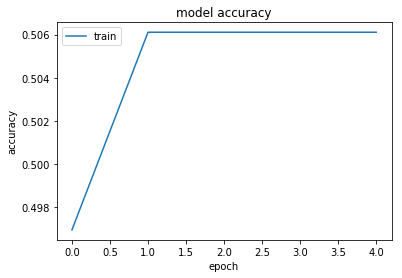

In [38]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

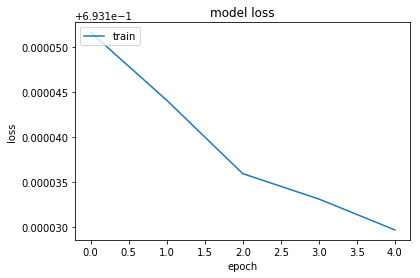

In [39]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [40]:
# Load trained network
model = load_model('./output/my_model.h5')

W0711 07:28:05.541199 140360590849920 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0711 07:28:05.545377 140360590849920 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
# Do prediction on test data
Y_pred=model.predict([X_test])

In [42]:
# Performance report
target_names = ["normal", "dme"]
print(classification_report(np.argmax(Y_test, axis=1), 
                            np.argmax(Y_pred, axis=1), 
                            target_names=target_names))

              precision    recall  f1-score   support

      normal       0.00      0.00      0.00       430
         dme       0.48      1.00      0.64       390

    accuracy                           0.48       820
   macro avg       0.24      0.50      0.32       820
weighted avg       0.23      0.48      0.31       820



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


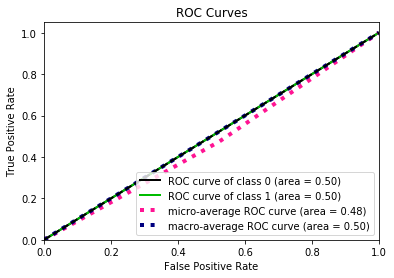

In [43]:
# Plot roc curve
skplt.metrics.plot_roc_curve(np.argmax(Y_test,axis=1), Y_pred)
plt.show()

In [44]:
# Show confusion matrix
confusion_matrix(np.argmax(Y_test,axis=1), 
                 np.argmax(Y_pred,axis=1))
model.metric()

AttributeError: ignored